# Importing Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from termcolor import colored as cl
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split as tts
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier # KNN algorithm
from sklearn.svm import SVC # SVM algorithm
from sklearn.ensemble import RandomForestClassifier # Random forest tree algorithm
from xgboost import XGBClassifier # XGBoost algorithm
import itertools
from sklearn.metrics import confusion_matrix # evaluation metric
from sklearn.metrics import accuracy_score # evaluation metric
from sklearn.metrics import f1_score # evaluation metric
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

# Importing the Dataset
* The dataset is downloaded from this [link](https://drive.google.com/file/d/1q3HENxnr5XeBTEdYT1rBO9BTdwnioB7H/view). Click that hyperlink to access the folder

In [ ]:
df = pd.read_json('/content/drive/MyDrive/transactions.zip (Unzipped Files)/transactions.txt', lines=True)
'Dataset Imported!!!'

'Dataset Imported!!!'

# Skimming through the dataset

## Looking at the top 5 rows of the dataset

In [ ]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.0,,,,True,,,False,False


## Looking for missing values, frequencies of different values and datatypes of the entries.

In [ ]:
# defining a function which can help us to achieve this
def skim_through_feature(data, columns):
  for col in columns:
    print(cl('________________________________', attrs=['bold']))
    print(cl(f'Feature Name: {col}', attrs=['bold']))
    print(data[col].value_counts())
    print(cl('________________________________', attrs=['bold']))


In [ ]:
skim_through_feature(df, df.columns)

________________________________
Feature Name: accountNumber
380680241    32850
882815134    13189
570884863    10867
246251253    10172
369308035     7229
             ...  
772075422        1
897071504        1
456500351        1
675656700        1
807705524        1
Name: accountNumber, Length: 5000, dtype: int64
________________________________
________________________________
Feature Name: customerId
380680241    32850
882815134    13189
570884863    10867
246251253    10172
369308035     7229
             ...  
772075422        1
897071504        1
456500351        1
675656700        1
807705524        1
Name: customerId, Length: 5000, dtype: int64
________________________________
________________________________
Feature Name: creditLimit
5000     201863
15000    139307
7500      97913
2500      75429
20000     68629
10000     56889
50000     48781
1000      36430
250       34025
500       27097
Name: creditLimit, dtype: int64
________________________________
____________________

* Some features has no variation i.e. all the instances have the exactly same value for those perticular feature.
* These features are as follows:
  * merchantZip
  * posOnPremises
  * recurringAuthInd
  * merchantCity
  * merchantState
  * accountNumber
  * customerId
  * echoBuffer

* Henxe, these feature will make no cointribution in prediction. It'll be better to drop these features.

In [ ]:
df = df.drop(columns=['merchantZip', 'posOnPremises', 'recurringAuthInd', 'merchantCity', 'merchantState','accountNumber', 'customerId', 'echoBuffer'])

## Splitting the fraud and non-fraud cases into two different dataframes

In [ ]:
fraud_df = df[df['isFraud']]
nonFraud_df = df[~df['isFraud']]

## Skimming through the statistics of Transaction Amount for fraud and non-fraud cases.

In [ ]:
print(cl('Statistics for Fraud Instances:', attrs=['bold']))
print(nonFraud_df.transactionAmount.describe())

Statistics for Fraud Instances:
count    773946.000000
mean        135.570249
std         146.525305
min           0.000000
25%          33.190000
50%          86.760000
75%         189.390000
max        2011.540000
Name: transactionAmount, dtype: float64


In [ ]:
print(cl('Statistics for Non-fraud Instances:', attrs=['bold']))
print(fraud_df.transactionAmount.describe())

Statistics for Non-fraud Instances:
count    12417.000000
mean       225.215905
std        189.551393
min          0.000000
25%         86.000000
50%        176.980000
75%        311.460000
max       1608.350000
Name: transactionAmount, dtype: float64


## Creating a copy of our current dataframe object *df*

In [ ]:
new_df = df.copy()

## It'll be good to scale the values of Transaction Amount using Standard Scaler due to high variation in the values.

In [ ]:
sc = StandardScaler()
new_df['transactionAmount'] = sc.fit_transform(new_df['transactionAmount'].values.reshape(-1,1))
new_df['transactionAmount'].head()

0   -0.260184
1   -0.422918
2   -0.876733
3   -0.876733
4   -0.445460
Name: transactionAmount, dtype: float64

## Features like transactionDateTime, currentExpDate, accountOpenDate, dateOfLastAddressChange can't be utilized by me. Hence, I'm gonna drop these features also. 

In [ ]:
new_df.drop(columns=['transactionDateTime', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange'], inplace= True)

## Replacing categorical values with numerical values to feed our model w/o any issue(in general)

### Replacing the entries of the feature **merchantName** categorical feature with its corresponding count of appearence of each values.

In [ ]:
merchantNameCount_df = new_df.groupby(['merchantName']).size().to_dict()

In [ ]:
# Adding to the main dataframe
new_df['merchantNameCount'] = new_df['merchantName'].map(merchantNameCount_df)
new_df.drop(columns=['merchantName'], inplace=True)

### Treating the features having missing values.

In [ ]:
# merchantCountryCode
new_df['merchantCountryCode'] = np.where((df.merchantCountryCode==''), 'X', new_df.merchantCountryCode)
new_df['merchantCountryCode'].value_counts()

US     778511
MEX      3143
CAN      2426
PR       1559
X         724
Name: merchantCountryCode, dtype: int64

In [ ]:
# posEntryMode
new_df['posEntryMode'] = np.where((new_df['posEntryMode']==''), 00, new_df.posEntryMode)
new_df['posEntryMode'].value_counts()

05    315035
09    236481
02    195934
90     19576
80     15283
0       4054
Name: posEntryMode, dtype: int64

In [ ]:
# posConditionCode
new_df['posConditionCode'] = np.where((new_df['posConditionCode']==''), 0, new_df.posConditionCode)
new_df['posConditionCode'].value_counts()

01    628787
08    149634
99      7533
0        409
Name: posConditionCode, dtype: int64

In [ ]:
# acqCountry
new_df['acqCountry'] = np.where((new_df.acqCountry == ''), 'Y', new_df.acqCountry)
new_df['acqCountry'].value_counts()

US     774709
Y        4562
MEX      3130
CAN      2424
PR       1538
Name: acqCountry, dtype: int64

In [ ]:
# transactionType
new_df['transactionType'] = np.where((new_df['transactionType'] == ''), 'X', new_df.transactionType)
new_df['transactionType'].value_counts()

PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
X                          698
Name: transactionType, dtype: int64

## Replacing the **merchantCategoryCode** with the mean w.r.t. the **transactionAmount**

In [ ]:
category_map = new_df.groupby(['merchantCategoryCode']).agg({'transactionAmount': 'mean'}).to_dict()['transactionAmount']
new_df['merchantCategoryCodeMaped'] = new_df['merchantCategoryCode'].map(category_map)

In [ ]:
# Dropping un necessary merchantCategoryCode feature from the dataframe
new_df.drop(columns=['merchantCategoryCode'], inplace=True)

## Replacing the entries of features *acqCountry*, *merchantCountryCode*, *posEntryMode*, *posConditionCode*, *transactionType* with their dummy values.

In [ ]:
new_df_acqCountry = pd.get_dummies(new_df['acqCountry'], prefix='acqCountry', drop_first=True)
new_df_acqCountry.head()

,acqCountry_MEX,acqCountry_PR,acqCountry_US,acqCountry_Y
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


In [ ]:
# Adding to the main dataframe
new_df = pd.concat([new_df, new_df_acqCountry], axis=1)

In [ ]:
new_df_ohe_modified = pd.get_dummies(new_df[['merchantCountryCode', 'posEntryMode', 'posConditionCode', 'transactionType']])
new_df = pd.concat([new_df, new_df_ohe_modified], axis=1)

## Replacing the entries of the features like *expirationDateKeyInMatch*, *isFraud*, *cardPresent* with numerical values using LabelEncoder

In [ ]:
le = LabelEncoder()
new_df_bool = pd.DataFrame()
new_df_bool['expirationDateKeyInMatch'] = le.fit_transform(new_df['expirationDateKeyInMatch'])
new_df_bool['isFraud'] = le.fit_transform(new_df['isFraud'])
new_df_bool['cardPresent'] = le.fit_transform(new_df['cardPresent'])

In [ ]:
new_df.drop(columns=['cardPresent', 'expirationDateKeyInMatch', 'isFraud'], inplace=True)
new_df = pd.concat([new_df, new_df_bool], axis=1)

In [ ]:
# Removing unnecessary columns
cols = ['merchantCountryCode', 'posEntryMode', 'posConditionCode','transactionType', 'acqCountry']
new_df.drop(columns=cols, inplace=True)

## Creating a new feature

In [ ]:
new_df['CVVmatched'] = np.where((new_df['cardCVV']==new_df['enteredCVV']), 1, 0)

In [ ]:
# Droping the prevoius 3 features
new_df.drop(columns=['enteredCVV', 'cardCVV', 'cardLast4Digits'], inplace=True)

# Splitting the dataset into Training and Test set

In [ ]:
X = new_df.drop(columns=['isFraud'], axis=1)
y = new_df['isFraud']
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((629090, 32), (157273, 32), (629090,), (157273,))

## Oversampling the data using SMOTE Technique

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 9924
Before OverSampling, counts of label '0': 619166 



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After OverSampling, the shape of train_X: (1238332, 32)
After OverSampling, the shape of train_y: (1238332,) 

After OverSampling, counts of label '1': 619166
After OverSampling, counts of label '0': 619166


## Implementing the Logistic Regression Algorithm based Model with suitable Hyperparameter.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

parameters = {
    'C': np.linspace(1, 10, 10)
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_train_res, y_train_res.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  4.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=3,
             param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

### Checking out the best hyperparameters

In [ ]:
clf.best_params_

{'C': 1.0}

### Building the final Model

In [ ]:
log_reg_fine = LogisticRegression(C=1, penalty='l2', verbose=5)
log_reg_fine.fit(X_train_res, y_train_res.ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.8s finished


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=5,
                   warm_start=False)

### Prediciting the test dataset labels

In [ ]:
y_test_pred_log_reg = log_reg_fine.predict(X_test)

## Implementing The Decision Tree Classifier Based Model

In [ ]:
def dtree_grid_search(X,y,nfolds):# can't operate , taking too much time
    #create a dictionary of all values we want to test
    param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 10)}
    # decision tree model
    dtree_model=DecisionTreeClassifier()
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds)
    #fit model to data
    dtree_gscv.fit(X, y)
    return dtree_gscv.best_params_

#dtree_grid_search(X_train_res, y_train_res, 5)

### Building the fine decision tree model

In [ ]:
tree_model = DecisionTreeClassifier(max_depth=5, criterion='entropy')
tree_model.fit(X_train_res, y_train_res)
y_test_pred_tree = tree_model.predict(X_test)

## Implementing the Random Forest Classifier

In [ ]:
rf_classifier = RandomForestClassifier(max_depth=4)
rf_classifier.fit(X_train_res, y_train_res)
y_test_pred_rf = rf_classifier.predict(X_test)

## Printing the Accuracy Score for each classifier:

In [ ]:
print(cl('Accuracy Score', attrs=['bold']))
print(f'Accuracy score for Decision Tree {accuracy_score(y_test, y_test_pred_tree)}')
print(f'Accuracy score for Random Forest {accuracy_score(y_test, y_test_pred_rf)}')
#print(f'Accuracy score for XGBoast {accuracy_score(y_test, y_predict_xgb)}')
print(f'Accuracy score for Logistic Regression {accuracy_score(y_test, y_test_pred_log_reg)}')

Accuracy Score
Accuracy score for Decision Tree 0.7972061320124878
Accuracy score for Random Forest 0.8027951396616075
Accuracy score for Logistic Regression 0.7059190070768664


## Printing F1 Score

In [ ]:
print(cl('F1 Score', attrs=['bold']))
print(f'F1_score for Decision Tree {f1_score(y_test, y_test_pred_tree)}')
print(f'F1_score for Random Forest {f1_score(y_test, y_test_pred_rf)}')
#print(f'F1_score for XGBoast {f1_score(y_test, y_predict_xgb)}')
print(f'F1_score for Logistic Regression {f1_score(y_test, y_test_pred_log_reg)}')

F1 Score
F1_score for Decision Tree 0.061389052383755145
F1_score for Random Forest 0.07015439964023384
F1_score for Logistic Regression 0.06178874982250441


## Plotting Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
class_names = [0,1]
plt.figure()


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Confusion Matrix for Logistic Regression Based Model


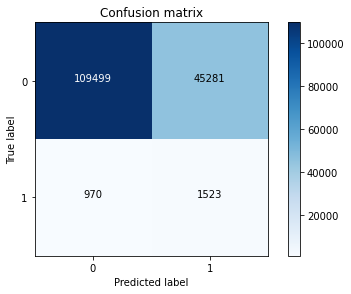

In [ ]:
print(cl('Confusion Matrix for Logistic Regression Based Model'))
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred_log_reg) , classes=class_names, title='Confusion matrix')

Confusion Matrix for Logistic Regression Based Model


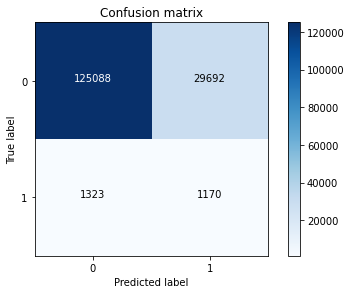

In [ ]:
print(cl('Confusion Matrix for Logistic Regression Based Model'))
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred_rf) , classes=class_names, title='Confusion matrix')

Confusion Matrix for Logistic Regression Based Model


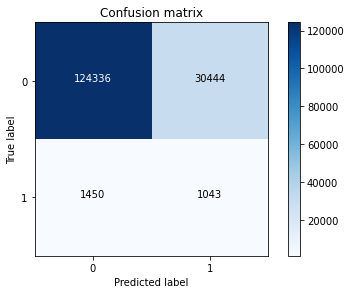

In [ ]:
print(cl('Confusion Matrix for Logistic Regression Based Model'))
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred_tree) , classes=class_names, title='Confusion matrix')

* Clearly the Random Forest Classifier Model is working better than any other model with an accuracy 80.28% and f1_score = 0.07

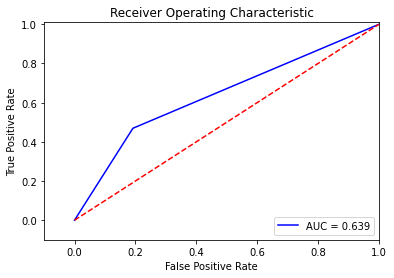

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_rf)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()